In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])
import matplotlib.pyplot as plt

# Import the backtrader platform
import backtrader as bt

# 创建celebro

In [2]:
# Create a cerebro entity
cerebro = bt.Cerebro()

# 编写交易策略

In [3]:
from strategies import MACDStrategy

# Create a Stratey
TestStrategy = MACDStrategy

# Add a strategy
cerebro.addstrategy(TestStrategy)

0

# 导入回测数据

In [4]:
# get data from AKShare
import akshare as ak
import pandas as pd

def get_data_from_akshare(symbol="QQQ", adjust="qfq"):
    data = ak.stock_us_daily(symbol=symbol, adjust=adjust).iloc[:,:7]
    # 把 date 作为日期索引，以符合 Backtrader 的要求
    data.index = pd.to_datetime(data['date'])
    return data

In [5]:
# Create a Data Feed
## load daily data from AKShare
stock_id = 'QQQ'
start_date = datetime.datetime(2024, 1, 1)  # 回测开始时间
end_date = datetime.datetime(2024, 12, 31)  # 回测结束时间
stock_qfq_df = get_data_from_akshare(symbol=stock_id)
## load data
data = bt.feeds.PandasData(dataname=stock_qfq_df, fromdate=start_date, 
                           todate=end_date, datetime='date', open='open', 
                           high='high',low='low', close='close', volume='volume')

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# 设置交易手续费

In [6]:
# 设置佣金
## IKBR pro用户，阶梯收费，忽略监管费用，只考虑佣金、交易所费用、清算费用
class IBKRProCommission(bt.CommInfoBase):
    params = (
        ('stocklike', True),  # 股票模式
    )

    def _getcommission(self, size, price, pseudoexec):
        # 根据交易量计算佣金
        volume = abs(size) * price
        if abs(size) <= 300000:
            commission_rate = 0.0035  # 0.35%
        elif abs(size) <= 3000000:
            commission_rate = 0.0020  # 0.20%
        elif abs(size) <= 20000000:
            commission_rate = 0.0015  # 0.15%
        elif abs(size) <= 100000000:
            commission_rate = 0.0010  # 0.10%
        else:
            commission_rate = 0.0005  # 0.05%

        commission = volume * commission_rate
        # 最多收取交易金额的1%
        commssion = min(commission, 0.01*volume)
        # 最少收取0.35美元
        commission = max(commission, 0.35)
        return commission

In [7]:
# 实例化自定义佣金类
ibkr_commission = IBKRProCommission()
# 添加到经纪商
cerebro.broker.addcommissioninfo(ibkr_commission)

# 添加评测指标

In [8]:
# 添加分析指标
# 返回年初至年末的年度收益率
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='_AnnualReturn')
# 计算最大回撤相关指标
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='_DrawDown')
# 计算年化收益：日度收益
cerebro.addanalyzer(bt.analyzers.Returns, _name='_Returns', tann=252)
# 计算年化夏普比率：日度收益
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='_SharpeRatio', timeframe=bt.TimeFrame.Days, annualize=True, riskfreerate=0) # 计算夏普比率
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='_SharpeRatio_A')
# 返回收益率时序
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='_TimeReturn')

# 开始回测

In [ ]:
# Set our desired cash start
cerebro.broker.setcash(1000.0)
# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
# Run over everything
result = cerebro.run()
# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

# 策略评测及可视化

{'年化收益率（%）': 4.853661450000013, '最大回撤（%）': -13.54105344295632, '年化夏普比率': None}


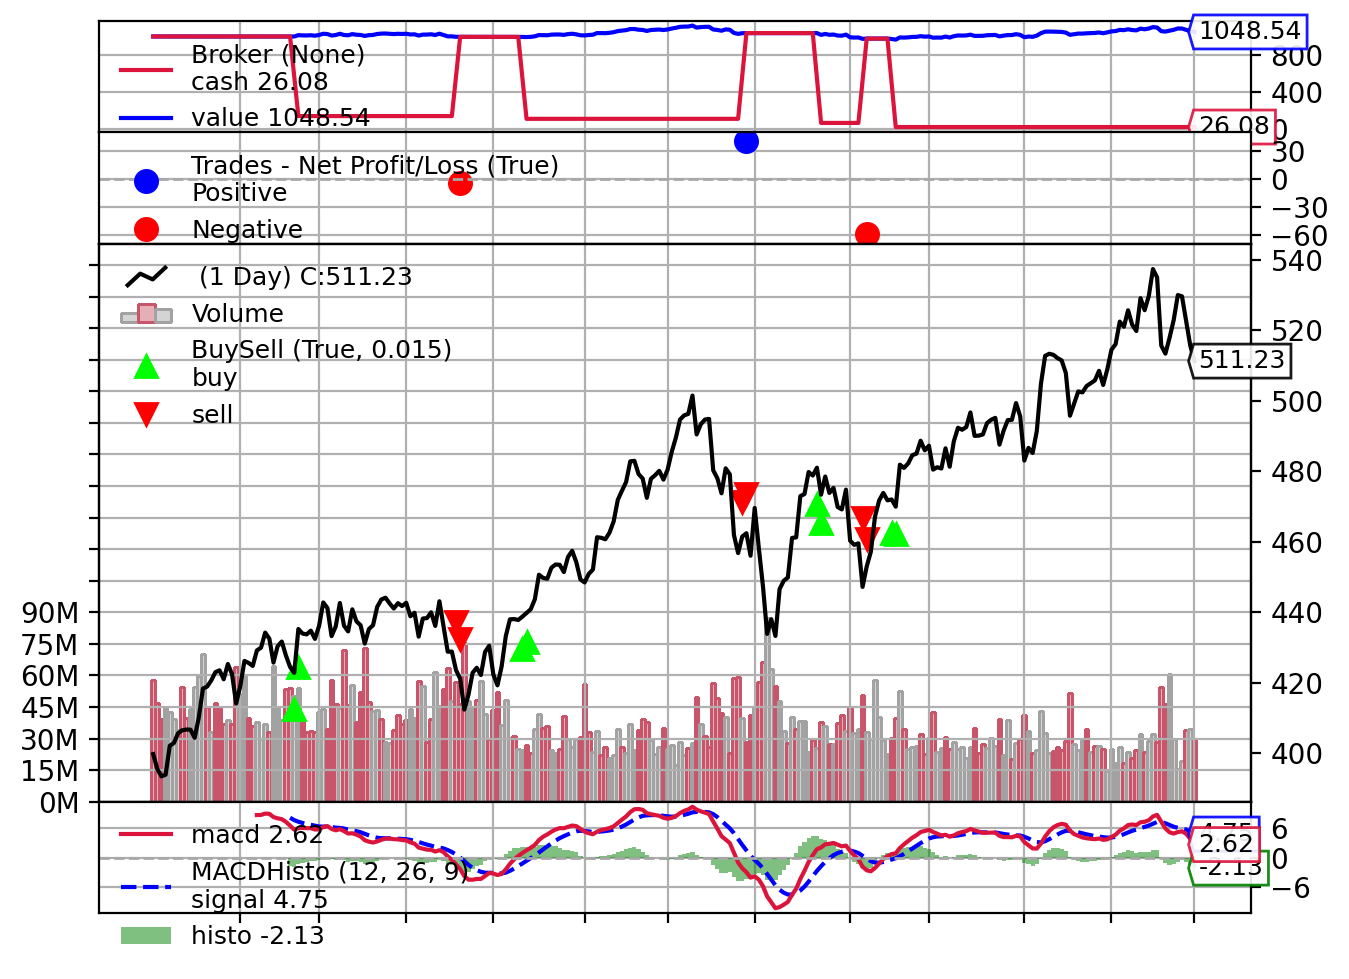

In [10]:
# 常用指标提取
analyzer = {}
# 提取年化收益
analyzer['年化收益率（%）'] = result[0].analyzers._Returns.get_analysis()['rnorm100']
# 提取最大回撤
analyzer['最大回撤（%）'] = result[0].analyzers._DrawDown.get_analysis()['max']['drawdown'] * (-1)
# 提取夏普比率
analyzer['年化夏普比率'] = result[0].analyzers._SharpeRatio_A.get_analysis()['sharperatio']
print(analyzer)

plt.clf()
%matplotlib inline
cerebro.plot(iplot=False)
plt.savefig('res.jpg')
plt.show()